In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import WeightedRandomSampler
from tqdm import tqdm
import numpy as np
import random
from sklearn.metrics import classification_report

In [4]:
seed = 6
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

In [5]:
PREFIX = '/content/drive/Shareddrives/TFQ/CSE_754_Fetal_Planes'
CSV_FILE = PREFIX + '/dataset/FETAL_PLANES_DB_data.xlsx'
IMAGE_DIR = PREFIX + '/dataset/Images'
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
DEVICE

device(type='cuda')

In [7]:
df = pd.read_excel(CSV_FILE)
df.columns

Index(['Image_name', 'Patient_num', 'Plane', 'Brain_plane', 'Operator',
       'US_Machine', 'Train '],
      dtype='object')

In [8]:
label_encoder = LabelEncoder()
df['Plane_Label'] = label_encoder.fit_transform(df['Plane'])
num_classes = len(label_encoder.classes_)
print(f"Classes found: {label_encoder.classes_}")

train_df = df[df['Train '] == 1].reset_index(drop=True)
test_df = df[df['Train '] == 0].reset_index(drop=True)

print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")

Classes found: ['Fetal abdomen' 'Fetal brain' 'Fetal femur' 'Fetal thorax'
 'Maternal cervix' 'Other']
Training samples: 7129
Testing samples: 5271


In [9]:
new_train_df, val_df = train_test_split(
    train_df,
    test_size=1000,
    stratify=train_df['Plane_Label'],
    random_state=42
)

print(f"New Training Set: {len(new_train_df)}")
print(f"Validation Set: {len(val_df)}")

class_counts = new_train_df['Plane_Label'].value_counts().sort_index().values
class_weights = len(new_train_df) / (len(class_counts) * class_counts)
class_weights_tensor = torch.FloatTensor(class_weights).to(DEVICE)

print(f"Class Weights (Loss): {class_weights}")

sample_weights = [1.0 / class_counts[label] for label in new_train_df['Plane_Label']]
sample_weights = torch.DoubleTensor(sample_weights)

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

New Training Set: 6129
Validation Set: 1000
Class Weights (Loss): [3.37128713 0.7333094  2.30067568 1.12252747 1.21174377 0.45684258]


In [10]:
class FetalPlaneDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform
        self.images = []

        print(f"Preloading {len(self.dataframe)} images into RAM...")
        for idx in tqdm(range(len(self.dataframe))):
            img_name = self.dataframe.iloc[idx]['Image_name'] + '.png'
            img_path = os.path.join(self.root_dir, img_name)
            try:
                image = Image.open(img_path).convert('RGB').resize((224, 224))
                self.images.append(image)
            except FileNotFoundError:
                self.images.append(Image.new('RGB', (224, 224)))

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.dataframe.iloc[idx]['Plane_Label']
        label = torch.tensor(label, dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        return image, label

In [14]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [12]:
train_dataset = torch.load(PREFIX + '/processed_datasets/train_dataset.pt', weights_only=False)
val_dataset   = torch.load(PREFIX + '/processed_datasets/val_dataset.pt', weights_only=False)
test_dataset  = torch.load(PREFIX + '/processed_datasets/test_dataset.pt', weights_only=False)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# ResNet

In [ ]:
model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

model = model.to(DEVICE)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 133MB/s]


# DenseNet

In [ ]:
model = models.densenet121(pretrained=True)

num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, num_classes)

model = model.to(DEVICE)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# MobileNet v3 Large

In [ ]:
model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V2)

num_ftrs = model.classifier[3].in_features
model.classifier[3] = nn.Linear(num_ftrs, num_classes)

model = model.to(DEVICE)

# SwinTransformer

In [ ]:
model = models.swin_v2_b(weights=models.Swin_V2_B_Weights.IMAGENET1K_V1)

num_ftrs = model.head.in_features
model.head = nn.Linear(num_ftrs, num_classes)

model = model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/swin_v2_b-781e5279.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_b-781e5279.pth


100%|██████████| 336M/336M [00:06<00:00, 51.8MB/s]


Model weights loaded successfully.


# ViT

In [ ]:
model = models.vit_b_16(pretrained=True)

num_ftrs = model.heads.head.in_features
model.heads.head = nn.Linear(num_ftrs, num_classes)

model = model.to(DEVICE)

c:\Users\Kazi Toufique Elahi\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Kazi Toufique Elahi\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Custom Model

In [15]:
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):

        g1 = self.W_g(g)
        x1 = self.W_x(x)

        psi = self.relu(g1 + x1)

        psi = self.psi(psi)

        return x * psi

In [16]:
class LiteFPNet(nn.Module):
    def __init__(self, input_channels=1, num_classes=2):
        super(LiteFPNet, self).__init__()

        self.enc1 = self._conv_block(input_channels, 32)
        self.enc2 = self._conv_block(32, 64)
        self.enc3 = self._conv_block(64, 128)
        self.enc4 = self._conv_block(128, 256)

        self.dec1 = self._upconv_block(256, 128)

        self.att1 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.dec2 = self._upconv_block(128 + 128, 64)

        self.att2 = AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.dec3 = self._upconv_block(64 + 64, 32)

        self.att3 = AttentionBlock(F_g=32, F_l=32, F_int=16)
        self.dec4 = self._upconv_block(32 + 32, 16)

        self.dnn_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def _conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2)
        )

    def _upconv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.1)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)

        d1 = self.dec1(e4)

        x3 = self.att1(g=d1, x=e3)
        d2 = self.dec2(torch.cat([d1, x3], dim=1))

        x2 = self.att2(g=d2, x=e2)
        d3 = self.dec3(torch.cat([d2, x2], dim=1))

        x1 = self.att3(g=d3, x=e1)
        d4 = self.dec4(torch.cat([d3, x1], dim=1))

        out = self.dnn_head(d4)
        return out


# Initialize Model
model = LiteFPNet(input_channels = 3, num_classes=num_classes)
model = model.to(DEVICE)



# Load Trained Weights

In [17]:
model = models.swin_v2_b(weights=models.Swin_V2_B_Weights.IMAGENET1K_V1)

num_ftrs = model.head.in_features
model.head = nn.Linear(num_ftrs, num_classes)

model = model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/swin_v2_b-781e5279.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_b-781e5279.pth


100%|██████████| 336M/336M [00:07<00:00, 47.3MB/s]


In [18]:
model.load_state_dict(torch.load(PREFIX + '/lite_fp_net.pth', map_location=DEVICE))
model.eval()

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=128, out_features=384, bias=True)
          (proj): Linear(in_features=128, out_features=128, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=4, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(appro

# Early Stopping

In [ ]:
import copy

class EarlyStopping:
    def __init__(self, patience, min_delta, mode='min', restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.counter = 0
        self.early_stop = False

        # Set initial best score based on mode
        self.best_score = float('inf') if mode == 'min' else float('-inf')

    def __call__(self, model, val_metric):
        """
        model: the model object (to save weights)
        val_metric: the loss or accuracy you are monitoring
        """
        if self.mode == 'min':
            score = -val_metric # convert to negative so we can maximize
            best = -self.best_score
        else:
            score = val_metric
            best = self.best_score

        # Check for improvement
        if score > best + self.min_delta:
            # Update best score
            self.best_score = val_metric
            self.counter = 0

            # Save the best weights in memory
            if self.restore_best_weights:
                self.best_model = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights and self.best_model:
                    print(f"Restoring model weights from the best epoch (Metric: {self.best_score:.4f})")
                    model.load_state_dict(self.best_model)

In [ ]:
es = EarlyStopping(
    patience=3,
    min_delta=0.001,
    mode='min',
    restore_best_weights=True
)

# Train & Test

In [19]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=0.00001,
                              betas=(0.9, 0.9999),
                              eps=1e-09,
                              weight_decay=0.08)

In [20]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'report': []}

    for epoch in range(num_epochs):

        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_preds / total_preds
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)


        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")


    return model, history

In [ ]:
trained_model, history_1 = train_model(model, train_loader, val_loader, criterion, optimizer, 10)

In [22]:
import numpy as np

def test_model(model, test_loader, device, label_encoder):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    accuracy = np.sum(all_preds == all_labels) / len(all_labels)

    print(f"Test Accuracy: {accuracy:.4f}")
    print("-" * 30)

    target_names = [str(cls) for cls in label_encoder.classes_]

    print("Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=target_names))



In [ ]:
test_model(model, test_loader, DEVICE, label_encoder)

### Save the Trained Model

In [ ]:
MODEL_SAVE_PATH = '/content/drive/MyDrive/CSE_754_Fetal_Planes/fetal_plane_classification_model.pth'

torch.save(trained_model.state_dict(), MODEL_SAVE_PATH)

print(f"Model saved successfully to: {MODEL_SAVE_PATH}")

Model saved successfully to: /content/drive/MyDrive/CSE_754_Fetal_Planes/fetal_plane_classification_model.pth


# Inference


In [23]:
from PIL import Image
import torch
import os

def get_image_class(image_name, model, label_encoder, image_dir, device, transform):
    image_path = os.path.join(image_dir, image_name)

    image = Image.open(image_path).convert('RGB')

    input_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        predicted_class_idx = torch.argmax(probabilities, dim=1).item()

    predicted_class_name = label_encoder.classes_[predicted_class_idx]

    return predicted_class_name, predicted_class_idx, probabilities.cpu().squeeze().numpy()

image_name = 'Patient00631_Plane2_1_of_1.png'
predicted_name, predicted_idx, probs = get_image_class(
    image_name, model, label_encoder, IMAGE_DIR, DEVICE, data_transforms
)

print(f"Image: {image_name}")
print(f"Predicted Class: {predicted_name} (Label: {predicted_idx})")
print("Probabilities:")
for i, prob in enumerate(probs):
    print(f"  {label_encoder.classes_[i]}: {prob:.4f}")


image_path = os.path.join(, image_name)
image = Image.open(image_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0).to(device)

Image: Patient00631_Plane2_1_of_1.png
Predicted Class: Fetal abdomen (Label: 0)
Probabilities:
  Fetal abdomen: 0.9987
  Fetal brain: 0.0001
  Fetal femur: 0.0000
  Fetal thorax: 0.0000
  Maternal cervix: 0.0001
  Other: 0.0009


In [ ]:
from PIL import Image
import torch
import os

def get_image_class(image_name, model, label_encoder, image_dir, device, transform):
    image_path = os.path.join(image_dir, image_name)

    image = Image.open(image_path).convert('RGB')

    input_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        predicted_class_idx = torch.argmax(probabilities, dim=1).item()

    predicted_class_name = label_encoder.classes_[predicted_class_idx]

    return predicted_class_name, predicted_class_idx, probabilities.cpu().squeeze().numpy()

image_name = 'Patient00631_Plane2_1_of_1.png'
predicted_name, predicted_idx, probs = get_image_class(
    image_name, model, label_encoder, IMAGE_DIR, DEVICE, data_transforms
)

print(f"Image: {image_name}")
print(f"Predicted Class: {predicted_name} (Label: {predicted_idx})")
print("Probabilities:")
for i, prob in enumerate(probs):
    print(f"  {label_encoder.classes_[i]}: {prob:.4f}")


image_path = os.path.join(, image_name)
image = Image.open(image_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0).to(device)

Image: Patient00631_Plane2_1_of_1.png
Predicted Class: Fetal abdomen (Label: 0)
Probabilities:
  Fetal abdomen: 0.9987
  Fetal brain: 0.0001
  Fetal femur: 0.0000
  Fetal thorax: 0.0000
  Maternal cervix: 0.0001
  Other: 0.0009


Image: Patient00631_Plane2_1_of_1.png
Predicted Class: Fetal abdomen (Label: 0)
Probabilities:
  Fetal abdomen: 0.9993
  Fetal brain: 0.0000
  Fetal femur: 0.0000
  Fetal thorax: 0.0000
  Maternal cervix: 0.0000
  Other: 0.0006


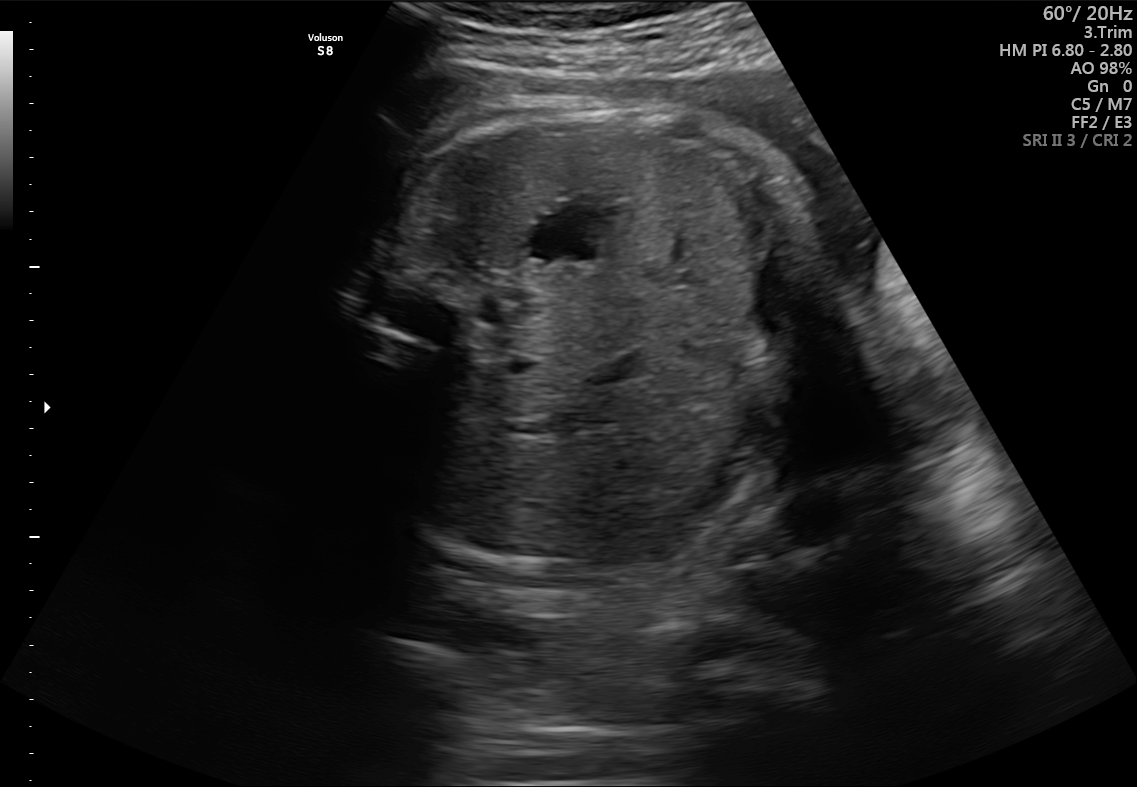

In [25]:
from PIL import Image
import torch
import os

def get_image_class(image_name, model, label_encoder, image_dir, device, transform):
    image_path = os.path.join(image_dir, image_name)

    image = Image.open(image_path).convert('RGB')

    input_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        predicted_class_idx = torch.argmax(probabilities, dim=1).item()

    predicted_class_name = label_encoder.classes_[predicted_class_idx]

    return predicted_class_name, predicted_class_idx, probabilities.cpu().squeeze().numpy()

image_name = 'Patient00631_Plane2_1_of_1.png'
predicted_name, predicted_idx, probs = get_image_class(
    image_name, model, label_encoder, IMAGE_DIR, DEVICE, data_transforms
)

print(f"Image: {image_name}")
print(f"Predicted Class: {predicted_name} (Label: {predicted_idx})")
print("Probabilities:")
for i, prob in enumerate(probs):
    print(f"  {label_encoder.classes_[i]}: {prob:.4f}")


image_path = os.path.join(IMAGE_DIR, image_name)
Image.open(image_path).convert('RGB')

# XAI (LIME)

In [ ]:
!pip install lime

In [27]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

def predict_fn(images):
    model.eval()

    processed_images = []
    for img in images:
        pil_img = Image.fromarray(img.astype('uint8'))
        processed_images.append(data_transforms(pil_img))

    input_tensor = torch.stack(processed_images).to(DEVICE)

    with torch.no_grad():
        outputs = model(input_tensor)

    probabilities = torch.nn.functional.softmax(outputs, dim=1)

    return probabilities.cpu().numpy()

In [28]:
import os
from PIL import Image
import numpy as np

image_name = 'Patient00631_Plane2_1_of_1.png'
image_path = os.path.join(IMAGE_DIR, image_name)

original_image = Image.open(image_path).convert('RGB')

image_np = np.array(original_image)

predictions = predict_fn(np.array([image_np]))

predicted_class_idx = np.argmax(predictions[0])
predicted_class_name = label_encoder.classes_[predicted_class_idx]


Predictions for Patient00631_Plane2_1_of_1.png:
  Fetal abdomen: 0.9998
  Fetal brain: 0.0000
  Fetal femur: 0.0000
  Fetal thorax: 0.0000
  Maternal cervix: 0.0000
  Other: 0.0002
Predicted class: Fetal abdomen (Label: 0)


In [ ]:
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    image_np,
    predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=100
)

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=True
)

plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title(f'LIME Explanation for Predicted Class: {predicted_class_name}')
plt.axis('off')
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]